In [2]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import matplotlib.pyplot as plt

%matplotlib notebook

Loading BokehJS ...

In [3]:
behavior_inference_model_code = """
data {
  int N;
  int y[N];
}


parameters {
  real<lower = 0> k;
  vector[N] v;
  vector<lower=0, upper=1>[N] r;
}


transformed parameters {
  real K = exp(k);
  vector[N] s;
  vector[N] n;
  
  s = r .* exp(-v);
  n = (1 - r) .* exp(-v);
}

model {
  // Priors
  k ~ uniform(-3, 3);
  v[1] ~ uniform(-3, 3);
  r[1] ~ uniform(0, 1);
  // Likelihood
  for (i in 2:N) {
    v[i] ~ normal(v[i-1], K);
    r[i] ~ beta(s[i], n[i-1]);
  }
  
  // Likelihood
  y ~ bernoulli_logit(r);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f7b0d6837fe6f3c9ce8f1fc1ae8500c NOW.


<IPython.core.display.Javascript object>


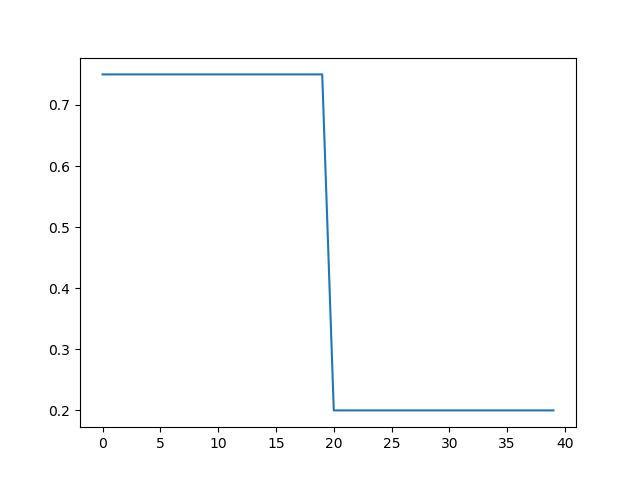

In [7]:
# Generate fake data from the model
# Build the true reward rate
true_prob = [0.75] * 20 + [0.2] * 20
plt.figure()
plt.plot(true_prob)

<IPython.core.display.Javascript object>


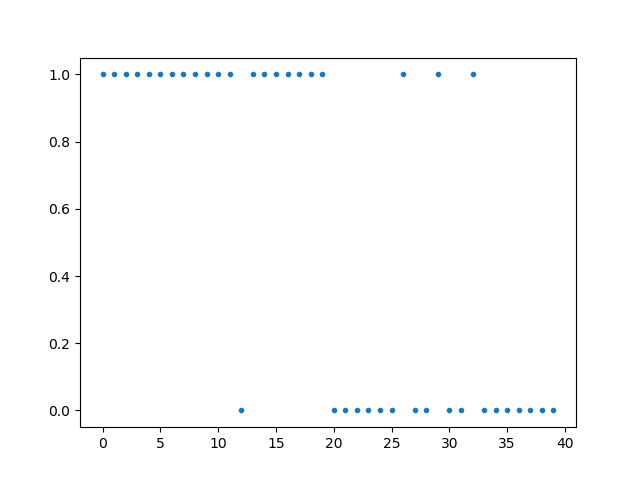

In [9]:
# Generate data from bernoulli
randvars = np.random.random(len(true_prob))
outcomes = randvars < true_prob
plt.figure()
plt.plot(outcomes, '.')
N = len(outcomes)

In [10]:
data_inf = dict(N=N,
               y=outcomes.astype('int'))

#init_prob = [dict(prob=np.ones(N) * 0.1)] * 4
samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=200, iter=1000, control={'max_treedepth':18})

In [62]:
bebi103.stan.check_all_diagnostics(samples_beh_inf)

n_eff / iter for parameter v[36] is 0.0009583254538065797.
n_eff / iter for parameter v[37] is 0.0009832177106888244.
n_eff / iter for parameter v[40] is 0.000995311263267851.
n_eff / iter for parameter r[9] is 0.0009577407360709171.
n_eff / iter for parameter prob[9] is 0.0009577407360709171.
  n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated.
Rhat for parameter k is 1.3813350917972145.
Rhat for parameter v[4] is 1.1613352914098403.
Rhat for parameter v[5] is 1.2102118456608906.
Rhat for parameter v[6] is 1.129790959367384.
Rhat for parameter v[7] is 1.2132222904817402.
Rhat for parameter v[8] is 1.3855571175440708.
Rhat for parameter v[9] is 1.6925988503594265.
Rhat for parameter v[10] is 1.4975623001443636.
Rhat for parameter v[11] is 1.6779546682376816.
Rhat for parameter v[12] is 1.7699983274335906.
Rhat for parameter v[13] is 1.6337422125518752.
Rhat for parameter v[14] is 1.5582537804894103.
Rhat for parameter v[15] is 1.52963961010

7

In [53]:
# Get samples of w1 and plot
plt.figure(figsize=(20,5))
n1samp = samples_beh_inf['prob']
means = np.mean(n1samp, axis=0)
std = np.std(n1samp, axis=0)


<Figure size 1440x360 with 0 Axes>

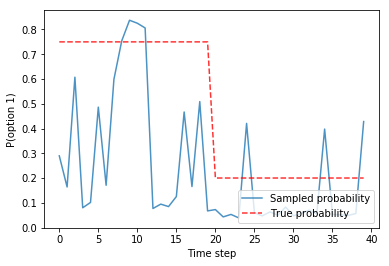

In [61]:
Nplot = 60
plt.plot(means, label='Sampled probability', alpha=0.8)
plt.plot(true_prob, 'r--', label='True probability', alpha=0.8)
plt.xlabel('Time step')
plt.ylabel('P(option 1)')
plt.legend(loc='lower right')
#plt.savefig('MCMC.pdf')

In [66]:
bokeh.io.show(bebi103.viz.trace_plot(samples_beh_inf, 
                                     pars=['prob[2]'], 
                                     inc_warmup=True))